In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.losses import CategoricalCrossentropy, binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization

# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(folder_path, label):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            img_array = img_to_array(img) / 255.0  # 이미지를 0-1 범위로 정규화
            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

# 데이터 경로
data_path = "./datasets/faces"
iu_faces_path = os.path.join(data_path, "IU_faces")
other_face1_path = os.path.join(data_path, "face1")
other_face2_path = os.path.join(data_path, "face2")

# IU_faces와 other_faces 데이터 로드 및 전처리
IMAGE_SIZE = 70  # 이미지 크기 조정
NUM_CLASSES = 3  # IU_faces와 other_faces의 클래스 수

iu_images, iu_labels = load_and_preprocess_data(iu_faces_path, label=0)
other1_images, other1_labels = load_and_preprocess_data(other_face1_path, label=1)
other2_images, other2_labels = load_and_preprocess_data(other_face2_path, label=2)

# 데이터 합치기
all_images = np.concatenate([iu_images, other1_images, other2_images], axis=0)
all_labels = np.concatenate([iu_labels, other1_labels, other2_labels], axis=0)

# 데이터를 훈련, 테스트로 나누기
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=50
)

#  검증 데이터 나누기
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=50
)




In [2]:
import tensorflow as tf
import keras
import numpy as np

### GPU 설정하기

https://chan-lab.tistory.com/13 참조


In [3]:
from tqdm import tqdm
import cv2
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

In [4]:
# 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    # rotation_range=20,  # 랜덤한 각도로 회전
    # width_shift_range=0.2,  # 좌우로 이동
    # height_shift_range=0.2,  # 상하로 이동
    # shear_range=0.2,  # 전단 변형
    # zoom_range=0.2,  # 랜덤한 확대/축소
    horizontal_flip=True,  # 좌우 반전
    # fill_mode='nearest'  # 채우기 모드
)

# 데이터 증강 적용 예시
augmented_images = []
augmented_labels = []

for i in tqdm(range(len(train_images))):
    img = train_images[i]
    label = train_labels[i]
    
    # 이미지를 4배로 증강
    for _ in range(4):
        augmented_img = datagen.random_transform(img)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)

# 증강된 데이터를 기존 데이터에 추가
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

train_images = np.concatenate([train_images, augmented_images], axis=0)
train_labels = np.concatenate([train_labels, augmented_labels], axis=0)


100%|███████████████████████████████████████████████████████████████████████████| 3350/3350 [00:00<00:00, 15043.20it/s]


In [5]:
print(train_images.shape, test_images.shape)
print(train_labels.shape, test_labels.shape)

(16750, 70, 70, 3) (1047, 70, 70, 3)
(16750,) (1047,)


In [6]:
# 모델 수정
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input')

# 1 step
x = Conv2D(filters=32, kernel_size=5, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=32, kernel_size=3, padding='valid')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(rate=0.25)(x)

# 2 step
x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=64, kernel_size=3, padding='valid')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(rate=0.25)(x)

# 3 step
x = Flatten()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 70, 70, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 70, 70, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 70, 70, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 70, 70, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 68, 68, 32)       128       
 hNormalization)                                             

In [7]:
# 모든 가용한 GPU 디바이스 확인
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # GPU 메모리 증가 허용 (선택 사항)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # 첫 번째 GPU만 사용하도록 설정 (선택 사항)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [8]:
4# 모델 컴파일 및 학습
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['acc'])

mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:02d}-{val_loss:.4f}.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    factor=0.1,
    mode='min',
    verbose=1
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=1
)

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks=[mcp_cb, rlr_cb, ely_cb]
)

Epoch 1/10
262/262 [==============================] - ETA: 0s - loss: 0.0876 - acc: 0.9723
Epoch 1: val_loss improved from inf to 1.23960, saving model to ./callback_files\weights.01-1.2396.h5
262/262 [==============================] - 11s 32ms/step - loss: 0.0876 - acc: 0.9723 - val_loss: 1.2396 - val_acc: 0.5155 - lr: 0.0010
Epoch 2/10
261/262 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9935
Epoch 2: val_loss improved from 1.23960 to 0.05640, saving model to ./callback_files\weights.02-0.0564.h5
262/262 [==============================] - 8s 30ms/step - loss: 0.0189 - acc: 0.9936 - val_loss: 0.0564 - val_acc: 0.9809 - lr: 0.0010
Epoch 3/10
261/262 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9955
Epoch 3: val_loss did not improve from 0.05640
262/262 [==============================] - 8s 29ms/step - loss: 0.0141 - acc: 0.9955 - val_loss: 0.4329 - val_acc: 0.8878 - lr: 0.0010
Epoch 4/10
261/262 [============================>.] - ETA: 0s - lo

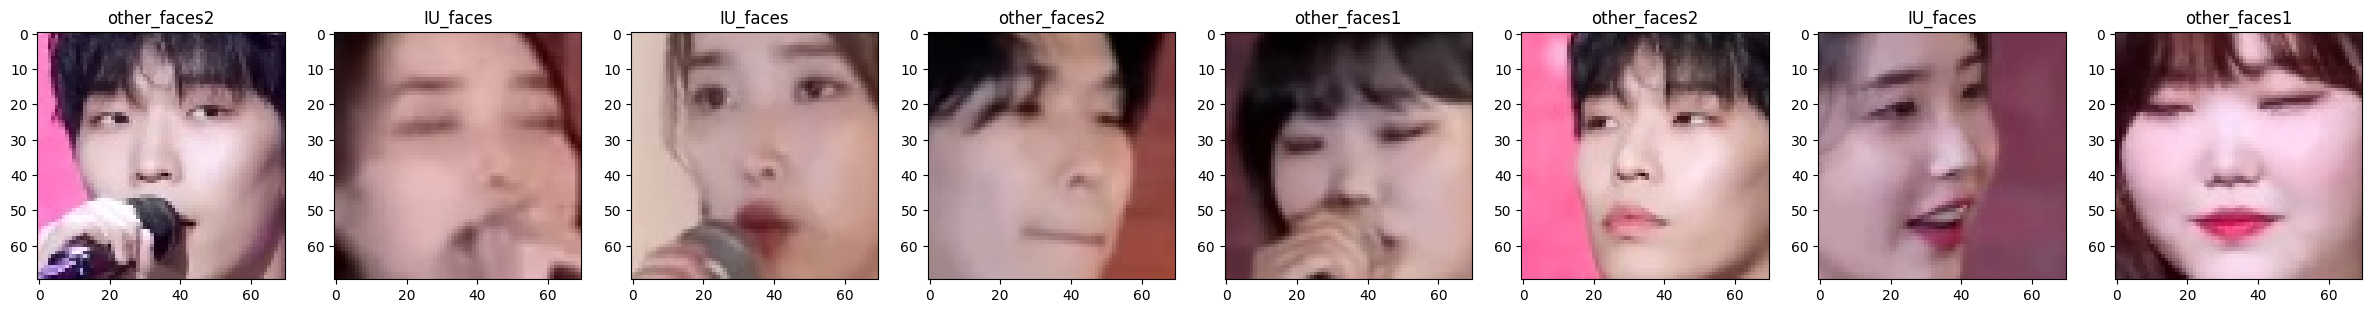

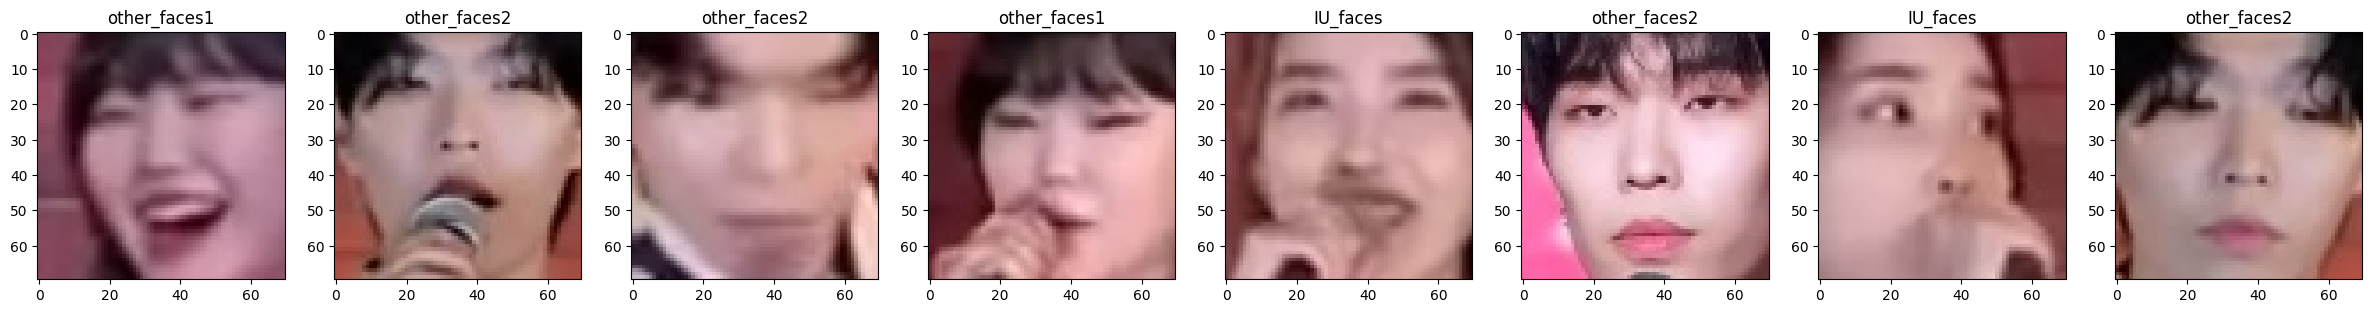

In [10]:
CLASS_NAMES = ["IU_faces", "other_faces1", "other_faces2"]

def show_images(images, targets, ncols=8):
    figure, axs = plt.subplots(figsize=(30, 8), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        target = targets[i].squeeze()
        axs[i].set_title(CLASS_NAMES[int(target)])
    
show_images(train_images[:8], train_labels[:8])
show_images(train_images[8:16], train_labels[8:16])

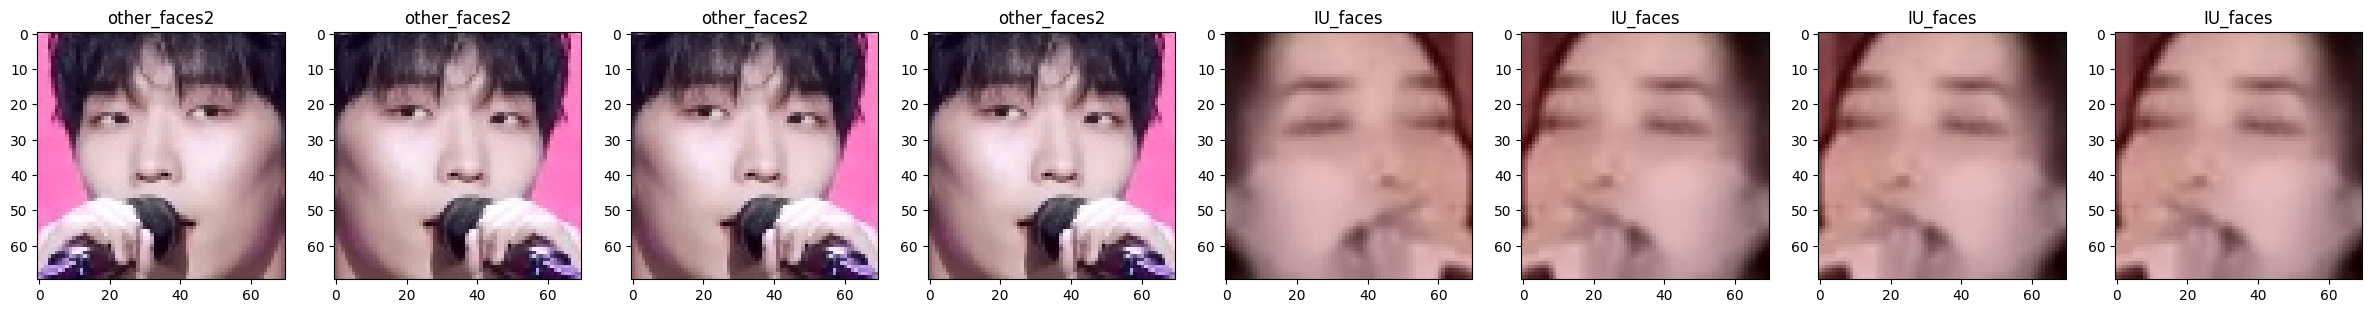

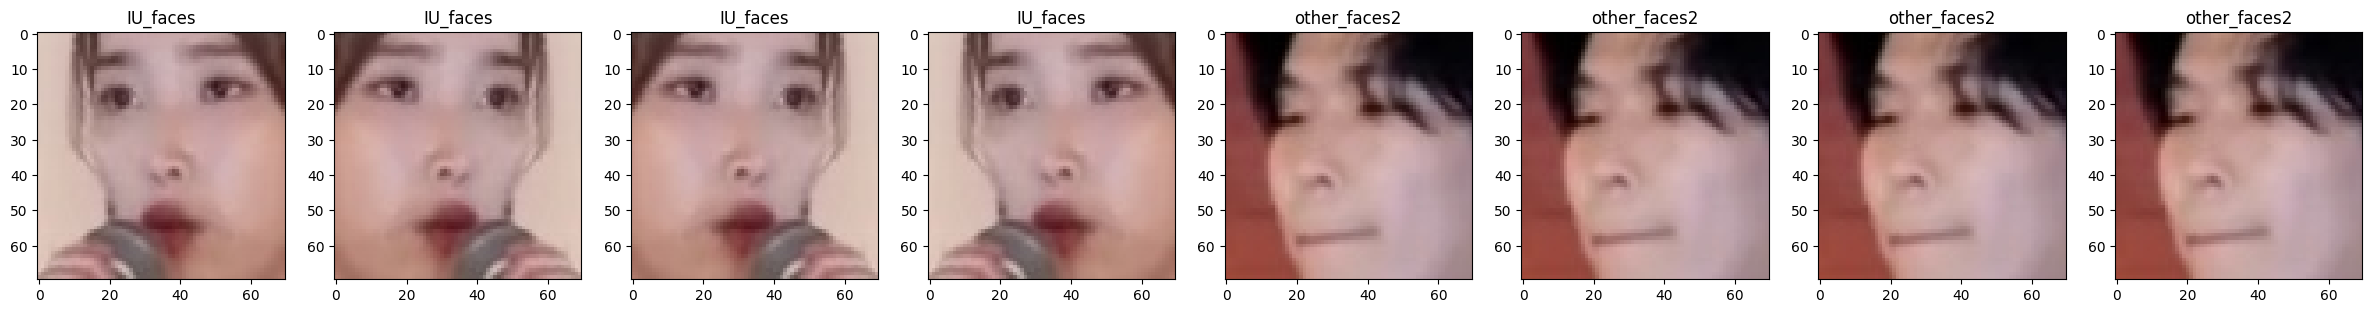

In [11]:
show_images(augmented_images[:8], augmented_labels[:8])
show_images(augmented_images[8:16], augmented_labels[8:16])

In [12]:
# 테스트 데이터로 모델 평가
model.evaluate(test_images, test_labels, batch_size=64)

# 예측
pred_probas = model.predict(test_images[16:24], batch_size=64)
predicted_classes = np.argmax(pred_probas, axis=1)
print(predicted_classes)


1/1 [==============================] - 0s 200ms/step
[2 0 2 0 2 0 2 2]


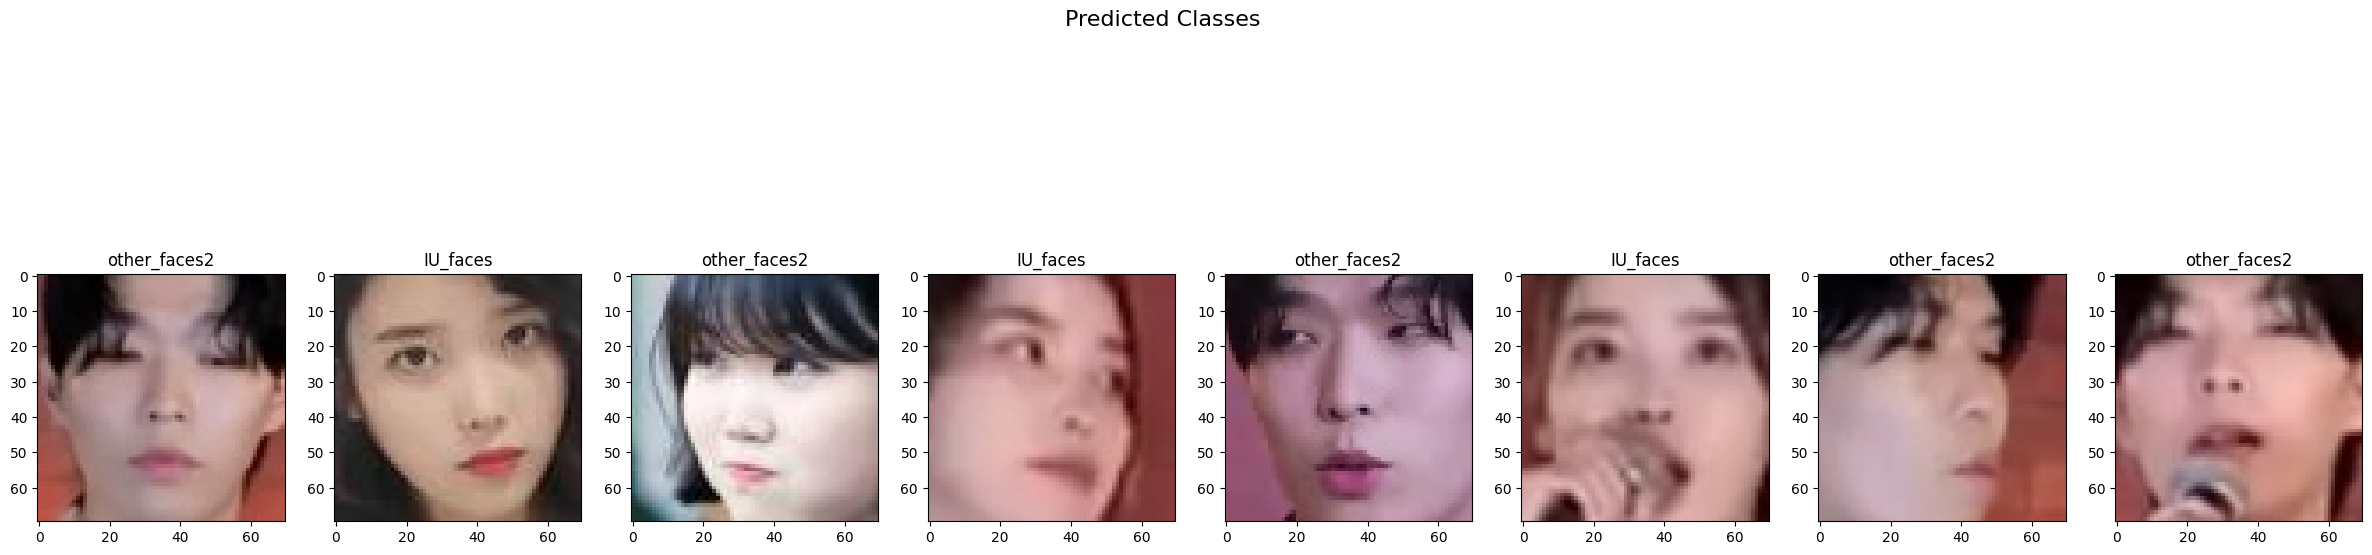

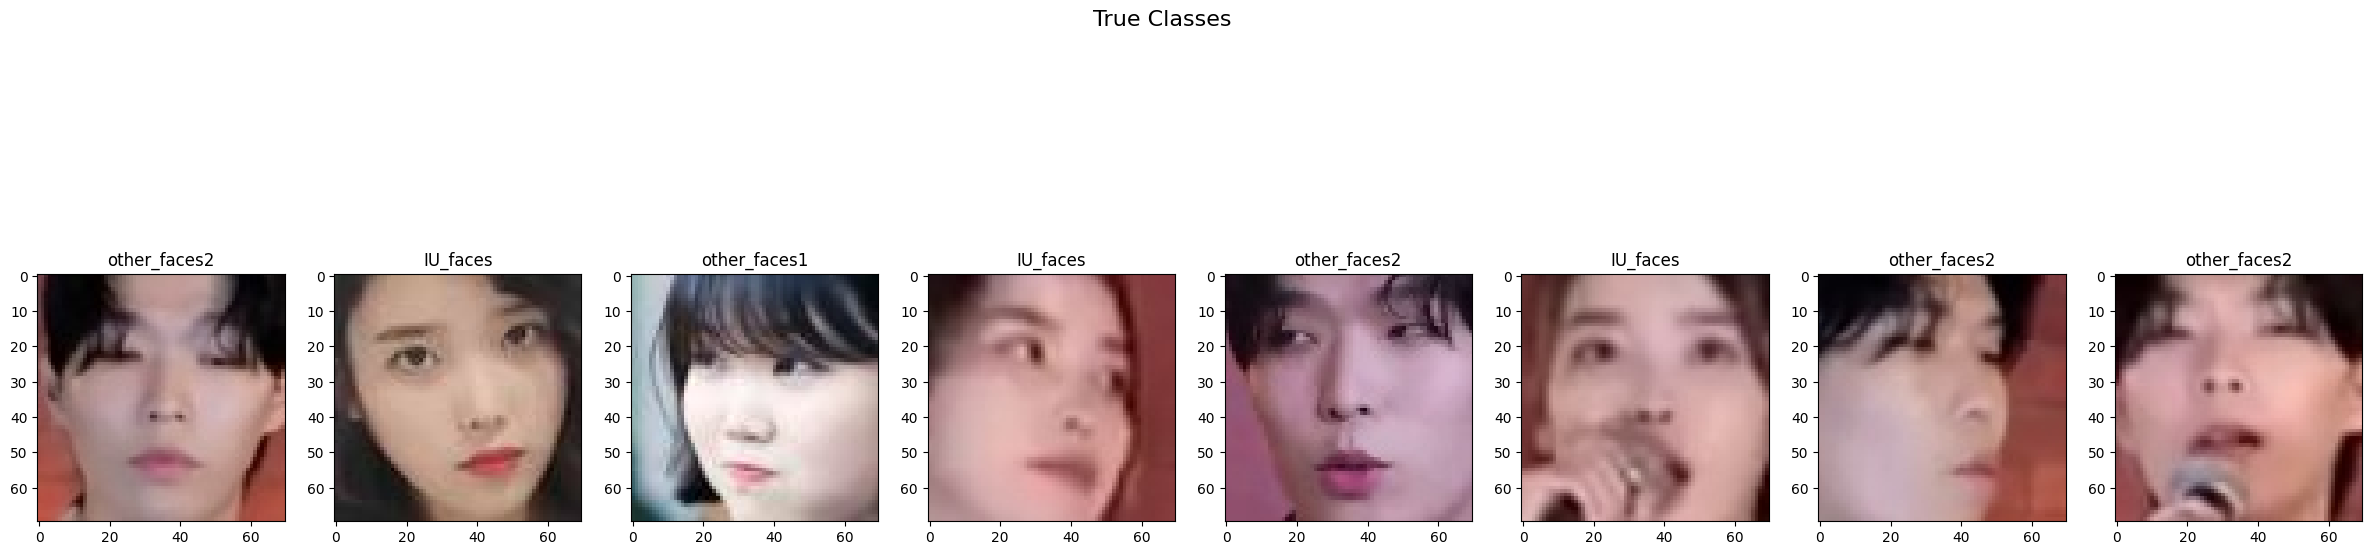

In [13]:
import matplotlib.pyplot as plt

# 예측된 클래스 시각화
show_images(test_images[16:24], predicted_classes[:8], ncols=8)
plt.suptitle('Predicted Classes', fontsize=16)  # 전체 제목 추가
plt.show()

# 실제 클래스 시각화
show_images(test_images[16:24], test_labels[16:24], ncols=8)
plt.suptitle('True Classes', fontsize=16)  # 전체 제목 추가
plt.show()

In [14]:
model.save('IU_face.h5')